# Setup

In [1]:
%%capture
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import os
import pandas as pd
import anndata as ad
import seaborn as sns
import numpy as np
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional,EstimatorSettings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

## Set up file paths

### demeter

In [2]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## Methods

### Differential Density

In [6]:
def log_density_ratio(
        adata,
        group_by,
        groups,
        latent_rep="X_umap",
        key_added="log_density_ratio",
        est_settings=None,
):
    if group_by not in adata.obs:
        raise ValueError(f"{group_by} is not a valid column key in 'adata.obs'")
    for group in groups:
        if group not in adata.obs[group_by].unique():
            raise ValueError(
                f"{group} is not a valid category of 'adata.obs.{group_by}' ({adata.obs[group_by].unique()})"
            )
    density = KDEMultivariateConditional(
        endog=adata.obsm[latent_rep],
        exog=np.array(adata.obs[group_by].values == groups[1]),
        dep_type="cc",
        indep_type="u",
        bw="normal_reference",
        defaults=est_settings
    )
    print(f"Calculating log density ratio of {groups[1]}/{groups[0]}")
    z1 = density.pdf(adata.obsm["X_umap"], 0 + np.zeros((adata.obsm["X_umap"].shape[0], 1)))
    z2 = density.pdf(adata.obsm["X_umap"], 1 + np.zeros((adata.obsm["X_umap"].shape[0], 1)))
    adata.obs[key_added] = np.log(z2/z1)  # group2 vs group1
    return adata

### Cluster abundance

In [4]:
def cluster_abundance_plot(adata, genotypes, include_cell_types="all", genotype_key="genotype", cell_type_key="cell_type", save_path=None, *args, **kwargs):
    data = {}
    for genotype in genotypes:
        data[genotype] = adata[(adata.obs[genotype_key] == genotype)]
    abundances = pd.DataFrame()
    for cell_type in adata.obs[cell_type_key].unique():
        fracs = {}
        for genotype, genotype_data in data.items():
            fracs[genotype] = len(genotype_data[genotype_data.obs[cell_type_key] == cell_type])/len(genotype_data)*100
        cell_type_data = pd.DataFrame(fracs, index=["pct_of_total"]).T
        cell_type_data["genotype"] = cell_type_data.index
        cell_type_data["cell_type"] = cell_type
        abundances = pd.concat([abundances, cell_type_data])
    if include_cell_types != "all":
        abundances = abundances[abundances.cell_type.isin(include_cell_types)]
    abundances.cell_type = abundances.cell_type.astype("category")
    abundances.cell_type.cat.remove_unused_categories()
    if include_cell_types != "all":
        abundances.cell_type.cat.reorder_categories(include_cell_types, inplace=True)
    display(abundances)
    ax = sns.barplot(
        data=abundances,
        x="cell_type",
        y="pct_of_total",
        hue="genotype",
        *args, **kwargs
    )
    ax.grid(False)
    plt.xticks(rotation = 90)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

## Import data

In [3]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")

# WT vs Fezf2 KO

## Differential Density

In [9]:
adata = log_density_ratio(
    adata,
    group_by="genotype",
    groups=("WT", "Fezf2_KO"),
    key_added = "Fezf2_KO/WT_genotype_density",
)

Calculating log density ratio of Fezf2_KO/WT


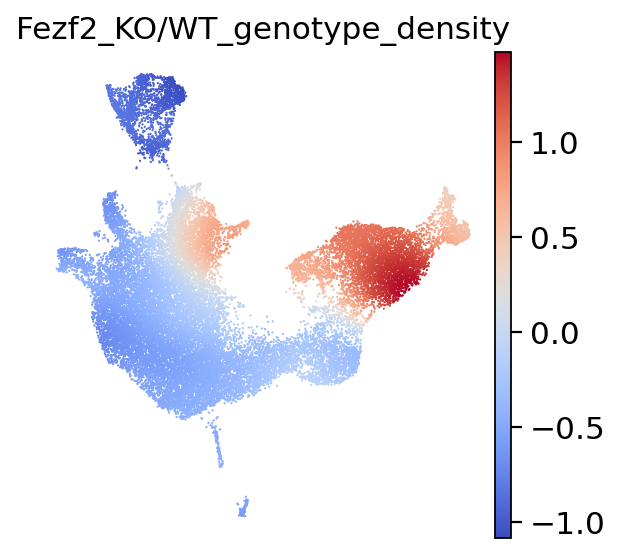

In [10]:
sc.settings.figdir = "../../analysis/Paper figs/1 (fezf2KO)"
sc.pl.umap(
    adata,
    color="Fezf2_KO/WT_genotype_density",
    cmap="coolwarm",
    save="_1C_differential_density.pdf",
)

## Cluster abundance

### all clusters

/tmp/ipykernel_3288/1581214315.py:19: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  abundances.cell_type.cat.reorder_categories(include_cell_types, inplace=True)


,pct_of_total,genotype,cell_type
WT,22.911309,WT,Late Aire
Fezf2_KO,11.647887,Fezf2_KO,Late Aire
WT,9.682435,WT,Tuft
Fezf2_KO,1.478873,Fezf2_KO,Tuft
WT,12.248071,WT,Ccl21a+
Fezf2_KO,41.661972,Fezf2_KO,Ccl21a+
WT,25.536750,WT,Aire+
Fezf2_KO,15.366197,Fezf2_KO,Aire+
WT,2.768973,WT,cTECs
Fezf2_KO,4.140845,Fezf2_KO,cTECs


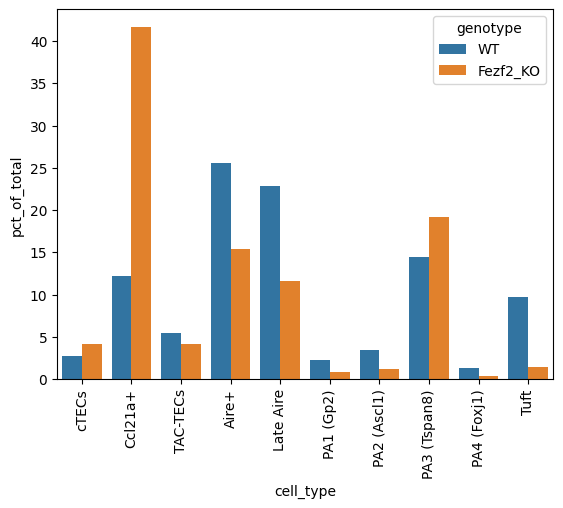

In [5]:
# All clusters
cluster_abundance_plot(
    adata,
    ["WT", "Fezf2_KO"],
    include_cell_types=["cTECs", "Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    save_path="../../analysis/Paper figs/S2 (Fezf2 KO)/S2A_cell_type_abundances.pdf"
)

### subset clusters

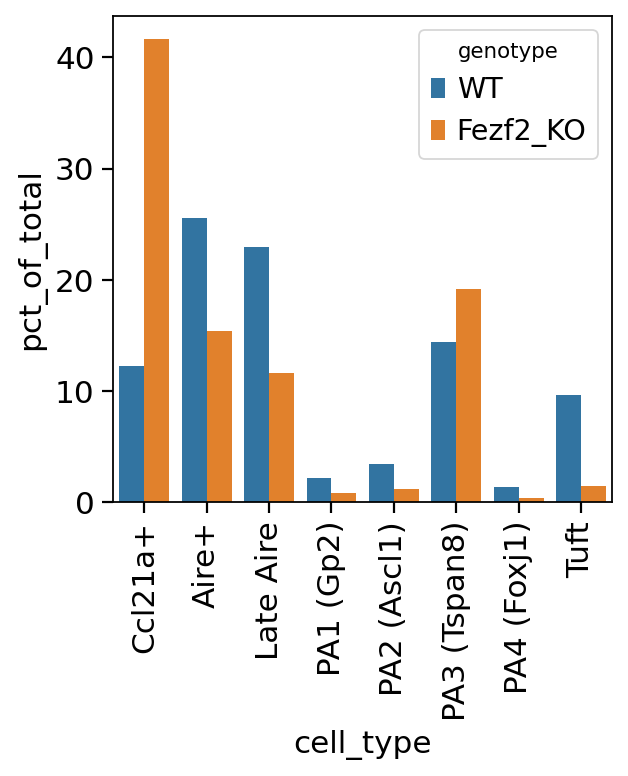

In [12]:
# Subset clusters
cluster_abundance_plot(
    adata,
    ["WT", "Fezf2_KO"],
    include_cell_types=["Ccl21a+", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    save_path="../../analysis/Paper figs/1 (fezf2KO)/1D_cell_type_abundances.pdf"
)

# WT vs Aire KO

## Differential density

In [13]:
adata = log_density_ratio(
    adata,
    group_by="genotype",
    groups=("WT", "Aire_KO"),
    key_added = "Aire_KO/WT_genotype_density",
)

Calculating log density ratio of Aire_KO/WT


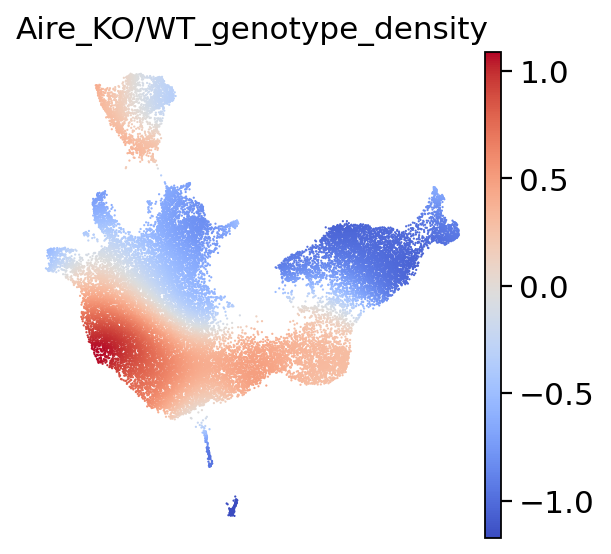

In [14]:
sc.settings.figdir = "../../analysis/Paper figs/2 (AireKO)"
sc.pl.umap(
    adata,
    color="Aire_KO/WT_genotype_density",
    cmap="coolwarm",
    save="_2B_differential_density.pdf",
)

## Cluster abundance

### all clusters

/tmp/ipykernel_3288/1581214315.py:19: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  abundances.cell_type.cat.reorder_categories(include_cell_types, inplace=True)


,pct_of_total,genotype,cell_type
WT,22.911309,WT,Late Aire
Aire_KO,39.783153,Aire_KO,Late Aire
WT,9.682435,WT,Tuft
Aire_KO,8.457048,Aire_KO,Tuft
WT,12.248071,WT,Ccl21a+
Aire_KO,2.985822,Aire_KO,Ccl21a+
WT,25.536750,WT,Aire+
Aire_KO,33.711426,Aire_KO,Aire+
WT,2.768973,WT,cTECs
Aire_KO,0.517098,Aire_KO,cTECs


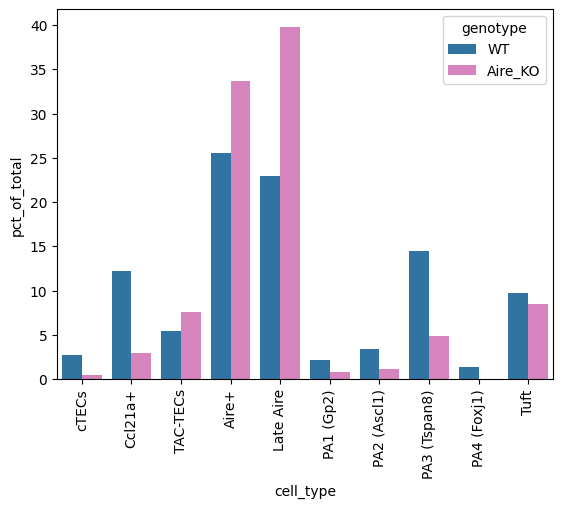

In [6]:
# All clusters
cluster_abundance_plot(
    adata,
    ["WT", "Aire_KO"],
    include_cell_types=["cTECs", "Ccl21a+", "TAC-TECs", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    save_path="../../analysis/Paper figs/S3 (Aire KO)/S3A_cell_type_abundances.pdf",
    palette=["tab:blue", "tab:pink"],
)

### subset clusters

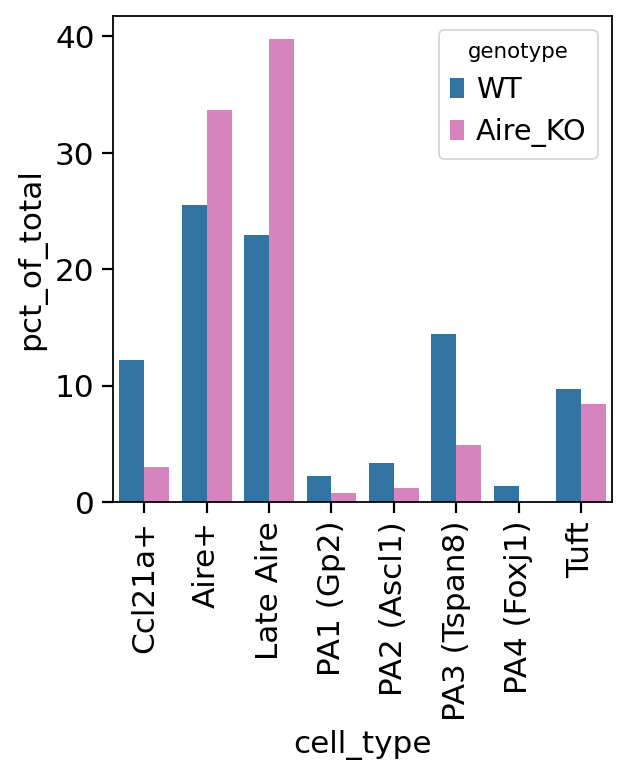

In [16]:
# Subset clusters
cluster_abundance_plot(
    adata,
    ["WT", "Aire_KO"],
    include_cell_types=["Ccl21a+", "Aire+", "Late Aire", "PA1 (Gp2)", "PA2 (Ascl1)", "PA3 (Tspan8)", "PA4 (Foxj1)", "Tuft"],
    save_path="../../analysis/Paper figs/2 (AireKO)/2C_cell_type_abundances.pdf",
    palette=["tab:blue", "tab:pink"],
)

# Pi chart comparison

In [9]:
adata.obs["merged_cell_type"] = adata.obs.cell_type.copy()
adata.obs.merged_cell_type = adata.obs.merged_cell_type.replace({
    "PA1 (Gp2)": "Post Aire",
    "PA2 (Ascl1)": "Post Aire",
    "PA3 (Tspan8)": "Post Aire",
    "PA4 (Foxj1)": "Post Aire"
})

In [55]:
genotypeCellTypeCounts = {}
for genotype in adata.obs.genotype.unique():
    genotypeData = adata[adata.obs.genotype == genotype]
    cellTypeCounts = genotypeData.obs.cell_type.value_counts()
    genotypeCellTypeCounts[genotype] = cellTypeCounts
genotypeCellTypeCounts = pd.DataFrame(genotypeCellTypeCounts)

In [56]:
genotypeCellTypeCounts = genotypeCellTypeCounts/genotypeCellTypeCounts.sum()

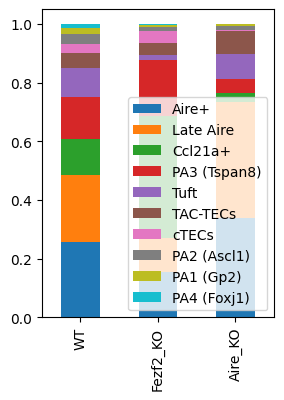

In [65]:
genotypeCellTypeCounts.T.plot(kind="bar", stacked=True, figsize=(3,4))
plt.savefig("../../analysis/Paper figs/3 (M cells)/3A_cell_type_proportion.pdf", bbox_inches="tight", dpi=300)
plt.show()